## DA3 Assignment 3 - Nicolas Fernandez and Arbash Malik

# 1. Loading Helper Libraries

In [156]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import re
import ast
import patsy
import datetime
import math
import statsmodels.api as sm
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import time
import plotly

from pathlib                         import Path
from plotnine                        import *
from stargazer                       import stargazer
from patsy                           import dmatrices
from collections                     import defaultdict
from plotnine.data                   import mpg
from mizani.formatters               import percent_format
from statsmodels.tools.eval_measures import mse,rmse
from plotly.express import *

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble        import HistGradientBoostingRegressor,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.linear_model    import LinearRegression, LogisticRegression, LogisticRegressionCV, ElasticNet,Lasso
from sklearn.metrics         import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error, accuracy_score
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.inspection      import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.tree            import DecisionTreeRegressor,DecisionTreeClassifier,plot_tree
from scipy.stats.mstats      import winsorize

In [2]:
path = Path(os.getcwd())
tech_prep = os.path.join(str(path), "utils")
sys.path.append(tech_prep)
from py_helper_functions import *

# Defining helper Functions

In [3]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

# 2. Loading Dataset

In [4]:
main_df = pd.read_csv('cs_bisnode_panel.csv')

In [5]:
main_df.shape

(287829, 48)

In [6]:
main_df = (main_df.set_index(["year", "comp_id"]).unstack(fill_value="toReplace").stack().reset_index())
main_df = main_df.replace("toReplace", np.nan) 

In [7]:
main_df.shape

(556944, 48)

In [8]:
main_df["status_alive"] = (main_df["sales"] > 0 & (False == main_df["sales"].isna())).astype(int)

main_df["default"] = ((main_df["status_alive"] == 1) & (main_df.groupby("comp_id")["status_alive"].shift(-1) == 0)).astype(int)

In [9]:
main_df = main_df[(main_df['ind2'] == 26) & (main_df['status_alive'] == 1)]

# 3. Feature Engineering

#### Transforming and Creating `Sales` variables
Here we examing the data and create columns to better organize and sort the data. The sales column in particular we take the log values of in order to normalize the distribution and then also take the squared values of that to account for any potential non-linearity in the data.

We also examine the difference of sales year to year with the `d1_` columns within the data.

In [10]:
main_df["sales"]    = np.where(main_df["sales"] < 0, 1, main_df["sales"])
main_df["sales_ln"] = np.where(main_df["sales"] > 0, np.log(main_df["sales"]),(np.where(main_df["sales"].isna(), np.nan, 0)))

main_df["sales_mil"]      = main_df["sales"] / 1000000
main_df["sales_mil_ln"]    = np.where(main_df["sales_mil"] > 0, np.log(main_df["sales_mil"]/ 1000000),(np.where(main_df["sales_mil"].isna(), np.nan, 0)))
main_df["sales_mil_ln_sq"] = main_df["sales_mil_ln"] ** 2

main_df["d1_sales_mil"]           = main_df["sales_mil"] - main_df.groupby("comp_id")["sales_mil"].shift(1)
main_df["d1_sales_mil_ln"]        = main_df["sales_mil_ln"] - main_df.groupby("comp_id")["sales_mil_ln"].shift(1)
main_df["d1_sales_mil_ln"]        = np.where(main_df["d1_sales_mil_ln"].isna(), 0, main_df["d1_sales_mil_ln"])
main_df["d1_sales_mil_ln_mod"]    = np.where(main_df["d1_sales_mil_ln"] < -1.5,-1.5,np.where(main_df["d1_sales_mil_ln"] > 1.5, 1.5, main_df["d1_sales_mil_ln"]))
main_df["d1_sales_mil_ln_mod_sq"] = main_df["d1_sales_mil_ln_mod"] ** 2

main_df["flag_low_d1_sales_mil_ln"]  = np.where(main_df["d1_sales_mil_ln"] < -1.5, 1, 0)
main_df["flag_high_d1_sales_mil_ln"] = np.where(main_df["d1_sales_mil_ln"] > 1.5, 1, 0)

#### Transforming and Creating `Firm Characteristic` variables
We created `foreign_management` as a dummy variable to represent firms where the majority stakeholder in the company is foreign as a 1 and 0 when it's not.

Along with this we created an `age` and `age_sq` column to represent the calculated age of the company, derived from the data by taking the difference between `year` and `founded_year`. In instances where `age` was less than or equal to 1 or where `ballsheet_notfullyear` was equal to 1, we created the dummy variable `new` to indicate that the company is to be considered new when these conditions are met.

Also, we modified the `d1_sales_mil_ln` to account for when a company is considered to be new.

In [11]:
# Firm characteristics
main_df["foreign_management"] = np.where(main_df["foreign"] >= 0.5, 1, np.where(main_df["foreign"].isna(), np.nan, 0))

main_df["age"]  = np.where(main_df["year"] - main_df["founded_year"] < 0, 0, main_df["year"] - main_df["founded_year"])
main_df["age_sq"] = main_df["age"] ** 2

main_df["new"] = np.where(((main_df["age"] <= 1) | (main_df["balsheet_notfullyear"] == 1)),1,(np.where(main_df["age"].isna(), np.nan, 0)),)
main_df["new"] = np.where(main_df["d1_sales_mil_ln"].isna(), 1, main_df["new"])

main_df["d1_sales_mil_ln"] = np.where(main_df["new"] == 1, 0, np.where(main_df["new"].isna(), np.nan, main_df["d1_sales_mil_ln"]))

#### Transforming and Creating `Financial` variables
Here we created a flag `flag_asset_problem` where any of the assets columns were showing as less than 0 because assets cannot be negative. In these instances we also changed the negative values to 0 in the respective columns.

We then created a total assets column `total_assets_bs` that combines all the assets columns.

In [12]:
# Assets can't be negative. Adding a flag.
main_df["flag_asset_problem"] = np.where(((main_df["intang_assets"] < 0)
                                           | (main_df["curr_assets"] < 0)
                                           | (main_df["fixed_assets"] < 0)),1,0,)

main_df["flag_asset_problem"] = np.where(((main_df["intang_assets"].isna())
                                           | (main_df["curr_assets"].isna())
                                           | (main_df["fixed_assets"].isna())),np.nan,main_df["flag_asset_problem"],)

In [13]:
# Assets can't be negative. Changing negative values to 0.
main_df["intang_assets"] = np.where(main_df["intang_assets"] < 0, 0, main_df["intang_assets"])
main_df["curr_assets"]   = np.where(main_df["curr_assets"]   < 0, 0, main_df["curr_assets"])
main_df["fixed_assets"]  = np.where(main_df["fixed_assets"]  < 0, 0, main_df["fixed_assets"])

In [14]:
# Creating a total asset column
main_df["total_assets_bs"] = (main_df["intang_assets"] + main_df["curr_assets"] + main_df["fixed_assets"])

Here we assign the columns that contain profit/loss information and columns that contain balance sheet information to their own variables to then divide them by sales and total assets respectively for the creation of ratio variables. In any instances where the division resulted in either infinity, negative infinity, or null values we imputed these values as 0 instead because it indicated there was a problem with the data.

In [15]:
# Creating profit and loss variables 
profit_loss_variables = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]

# Creating balance sheet variables 
balance_sheet_variables = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

# Dividing all profit loss and balance sheet variables by sales and creating a new column for it
main_df[[col + "_pl" for col in profit_loss_variables]] = (main_df[profit_loss_variables].div(main_df["sales"], axis="index").replace((np.inf, -np.inf, np.nan), (0, 0, 0)))
main_df[[col + "_bs" for col in balance_sheet_variables]] = (main_df[balance_sheet_variables].div(main_df["total_assets_bs"], axis="index").replace((np.inf, -np.inf, np.nan), (0, 0, 0)))

# Get null values where total_assets_bs is NaN
for col in balance_sheet_variables: 
    main_df[col + "_bs"] = np.where(main_df["total_assets_bs"].isna(), np.nan, main_df[col + "_bs"])

### Creating flags
Here we create flags on the columns created above to denote when there's a ratio that's outside of the 0-1 range for whatever reason.

In [16]:
# Variables that represent accounting items that cannot be negative (e.g. materials)

acc_vars = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

main_df[[col + "_flag_high" for col in acc_vars]]  = np.where(main_df[acc_vars].isna(), np.nan, (main_df[acc_vars] > 1).astype(int))
main_df[[col + "_flag_error" for col in acc_vars]] = np.where(main_df[acc_vars].isna(), np.nan, (main_df[acc_vars] < 0).astype(int))

main_df[[col for col in acc_vars]] = np.where(main_df[acc_vars].isna(), np.nan, np.where(main_df[acc_vars] > 1, 1, main_df[acc_vars]))
main_df[[col for col in acc_vars]] = np.where(main_df[acc_vars].isna(), np.nan, np.where(main_df[acc_vars] < 0, 0, main_df[acc_vars]))

In [17]:
# For variables that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

main_df[[col + "_flag_high" for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, (main_df[anyof] > 1).astype(int))
main_df[[col + "_flag_low"  for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, (main_df[anyof] < -1).astype(int))
main_df[[col + "_flag_zero" for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, (main_df[anyof] == 0).astype(int))
main_df[[col + "_quad"      for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, main_df[anyof] ** 2)


main_df[[col for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, np.where((main_df[anyof] < -1), -1, main_df[anyof]))
main_df[[col for col in anyof]] = np.where(main_df[anyof].isna(), np.nan, np.where((main_df[anyof] > 1), 1, main_df[anyof]))

For any of the flags that we created that don't have any standard deviation (i.e. nothing different denoted) we drop the flag columns.

In [18]:
# Dropping flag columns with 0 standard deviation
flag_columns = [col for col in main_df.columns if "flag" in col]
main_df = main_df.drop(main_df[flag_columns].std()[(main_df[flag_columns].std() == 0)].index, axis=1)

We create a variable `ceo_age` by calculating the difference between `year` and `birth_year` with `birth_year` being the year the CEO was born in. We then create flags to denote whether there is an issue with `ceo_age` (whether it's below 25 or above 75 or if there's a null value) and then also create `ceo_young` as a dummy variable that equals 1 when the CEO's age is less then 40.

In [19]:
# Creating CEO age variable and imputing 
main_df["ceo_age"] = main_df["year"] - main_df["birth_year"]

main_df = main_df.assign(flag_low_ceo_age  = (main_df["ceo_age"] < 25).astype(int),
                         flag_high_ceo_age = (main_df["ceo_age"] > 75).astype(int),
                         flag_miss_ceo_age = (main_df["ceo_age"].isna()).astype(int)
                        )
main_df["ceo_age"] = np.where(main_df["ceo_age"] < 25, 25, main_df["ceo_age"])
main_df["ceo_age"] = np.where(main_df["ceo_age"] > 75, 75, main_df["ceo_age"])
main_df["ceo_age"] = np.where(main_df["ceo_age"].isna(), main_df["ceo_age"].mean(), main_df["ceo_age"])

main_df["ceo_young"] = (main_df["ceo_age"] < 40).astype(int)

### Creating `First Difference` variables
These variables are created by taking the year-to-year difference between their respective columns in order to account for any potential growth or downsizing for each company.

In [20]:
main_df["d1_COGS"]             = main_df["COGS"] - main_df.groupby("comp_id")["COGS"].shift(1)
main_df["d1_curr_assets"]      = main_df["curr_assets"] - main_df.groupby("comp_id")["curr_assets"].shift(1)
main_df["d1_curr_liab"]        = main_df["curr_liab"] - main_df.groupby("comp_id")["curr_liab"].shift(1)
main_df["d1_inc_bef_tax"]      = main_df["inc_bef_tax"] - main_df.groupby("comp_id")["inc_bef_tax"].shift(1)
main_df["d1_net_dom_sales"]    = main_df["net_dom_sales"] - main_df.groupby("comp_id")["net_dom_sales"].shift(1)
main_df["d1_net_exp_sales"]    = main_df["net_exp_sales"] - main_df.groupby("comp_id")["net_exp_sales"].shift(1)
main_df["d1_wages"]            = main_df["wages"] - main_df.groupby("comp_id")["wages"].shift(1)
main_df["d1_profit_loss_year"] = main_df["profit_loss_year"] - main_df.groupby("comp_id")["profit_loss_year"].shift(1)
main_df["d1_fixed_assets"]     = main_df["fixed_assets"] - main_df.groupby("comp_id")["fixed_assets"].shift(1)
main_df["d1_inventories"]      = main_df["inventories"] - main_df.groupby("comp_id")["inventories"].shift(1)
main_df["d1_personnel_exp"]    = main_df["personnel_exp"] - main_df.groupby("comp_id")["personnel_exp"].shift(1)
main_df["d1_total_assets_bs"]  = main_df["total_assets_bs"] - main_df.groupby("comp_id")["personnel_exp"].shift(1)


### Dummy Variables
Below we create dummy variables to account for categorical columns in the data. For instance `gender_female` when the majority gender in the company is female and `region_east` when the region of the company is within the eastern portion of the United States. We also create dummy variables for each year within the data such as `year_2013` to denote whether the year in the data is 2013 since `year` is a categorical column.

In [21]:
main_df["default_f"] = main_df["default"].astype("category")
main_df["default_f"] = main_df["default_f"].cat.rename_categories(["no_default", "default"])
main_df["year_f"] = main_df["year"].astype("category")

# Creating dummy variables for gender and region
main_df['gender_female']  = (main_df.gender == 'female').astype(int)
main_df['gender_male']    = (main_df.gender == 'male').astype(int)
main_df['region_central'] = (main_df.region_m == 'Central').astype(int)
main_df['region_east']    = (main_df.region_m == 'East').astype(int)
main_df['urban_capital']  = (main_df.urban_m == 1).astype(int)
main_df['urban_bigcity']  = (main_df.urban_m == 2).astype(int)

In [22]:
year_dummies = pd.get_dummies(main_df['year'], prefix='year').astype(int)
main_df = pd.concat([main_df, year_dummies], axis=1)

In [23]:
for col in main_df.select_dtypes(include=["category"]).columns:
    main_df[col] = main_df[col].cat.remove_unused_categories()

In [24]:
main_df['sales'].describe()

count    1.320500e+04
mean     1.591749e+06
std      7.175393e+06
min      3.703704e+00
25%      2.098519e+04
50%      7.963334e+04
75%      3.505704e+05
max      1.107458e+08
Name: sales, dtype: float64

In [25]:
main_df.shape

(13205, 149)

# 4. Variable Selection
Here we select the variables to potentially include in all of our models, including interaction terms for the OLS and LASSO.

The columns assigned to variables are as follows:
- `sales_vars` - This includes the sales and transofmed sales columns as it is a great measure of a company's performance
- `quality_vars` - Here we include the balance sheet columns for accounting for transparency in their financial reporting
- `profit_loss_vars` - We account for the profit/loss of a company since this is also a measure of a company's performance
- `balance_sheet_vars` - Including the balance sheet variables since it can indicate whether a company is likley to default
- `human_capital_vars` - This represents characteristics of senior management for ecah company, for instance foreign majority CEOs or if the share of female CEOs is the majority
- `firm_charac_vars` - These represent characteristics of each company, for example if majority gender of personnel is female, or if the company is in the central region of Europe
- `d1_vars` - These account for changes in year-to-year across companies to check for trends, either positive or negative
- `engineered_vars` - These are to account for any trend in the data when examining the ratios that have been engineered from the data itself
- Interactions have been made between sales and certain categorical variables that may affect the `sales` column data, for example the majority gender of personnel or the region location of the company. These have been broken up into two difference variables, one to include in an OLS model and then the other to include in the LASSO.
- `flag_vars` - These are the accumulate all of the flag variables that were created and assign them to a variable

In [26]:
## Main Firm Variables ##
sales_vars = ["sales_mil","sales_ln","sales_mil_ln","sales_mil_ln_sq"]

quality_vars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

profit_loss_vars = ["extra_exp","extra_inc","extra_profit_loss","inc_bef_tax","inventories","material_exp","profit_loss_year","personnel_exp"]

d1_vars = ["d1_sales_mil", "d1_curr_assets", "d1_curr_liab", "d1_inc_bef_tax","d1_profit_loss_year", "d1_fixed_assets", "d1_inventories"
           , "d1_personnel_exp","d1_total_assets_bs","d1_sales_mil_ln","d1_sales_mil_ln_mod","d1_sales_mil_ln_mod_sq","flag_low_d1_sales_mil_ln","flag_high_d1_sales_mil_ln"]

balance_sheet_vars = ["intang_assets","curr_liab","fixed_assets","liq_assets","curr_assets","share_eq","subscribed_cap","tang_assets","total_assets_bs"]

engineered_vars = ["fixed_assets_bs", "liq_assets_bs","curr_assets_bs","share_eq_bs","subscribed_cap_bs","intang_assets_bs"
                   ,"extra_exp_pl","extra_inc_pl","extra_profit_loss_pl","inc_bef_tax_pl","inventories_pl","material_exp_pl","profit_loss_year_pl","personnel_exp_pl"
                   ,"extra_profit_loss_pl_quad","inc_bef_tax_pl_quad","profit_loss_year_pl_quad","share_eq_bs_quad"]

human_capital_vars = ["female","ceo_age","ceo_count","foreign_management"]

firm_charac_numeric = ["age", "age_sq", "new"]

firm_charac_cat = ['gender_female', 'gender_male', 'region_central', 'region_east','urban_capital','urban_bigcity']

interactions1 = ['gender_female*sales_ln','gender_male*sales_ln','region_central*sales_ln','region_east*sales_ln','urban_capital*sales_ln','urban_bigcity*sales_ln']

year_dummy_vars = year_dummies.columns.tolist()

flag_vars = []
for col in main_df.columns:
    if "flag" in col:
        flag_vars.append(col)   
        
        
flag_vars = [col for col in flag_vars if 'd1' not in col]

Here we create a function in order to winsorize the data in columns of our choosing. The penalties chosen given our data were the 1st percentile and the 90th percentile. The data has a long right tail due to some extreme values in the data and therefore a stricter 90 percent was used instead of the more classical 95 percent. We choose just the 1st percent because we want to account for the zombie firms that may exist that don't actually have any sales values or profit but also not discount the really small and/or struggling firms.

The columns that were selected to be winsorized were all of the manually created variables instead of the original data because winsorizing the original data could influence the holdout set that we are creating whereas the manually created variables would not do so and also we can make better inferences on the values of these columns as well since they were manually created.

In [27]:
def winsorize_columns(data, columns):
    data_copy = data.copy()
    for column in columns:
        if column in data_copy.columns:
            data_copy[column] = winsorize(data_copy[column], limits=(0.01, 0.1))  # Set limits to 1st and 90th percentiles
    return data_copy

to_winsorize = d1_vars + engineered_vars + flag_vars + human_capital_vars


main_df = winsorize_columns(main_df,to_winsorize)

Various tests for variable selection were made from results from the models. From testing, the variables below are the variables that resulted in the best performance of the models.

In [28]:
# changed order 3 = 0.5699
all_vars = sales_vars + profit_loss_vars + quality_vars + balance_sheet_vars + d1_vars + engineered_vars + firm_charac_numeric

_____________________________________________________________
# Split training and test datasets
Here we create the holdout set for our data. The specifics of the holdout set are as follows for firms:
- `ind2` == 26 (26 as the selected industry)
- Yearly sales in 2014 between 1000 and 10 million EUR (Small or Medium Enterprises)

In [29]:
holdout_df = main_df[(main_df['year'] == 2014) & (main_df['sales'] >= 1000) & (main_df['sales'] <= 10000000)]
train_df = main_df[~main_df.index.isin(holdout_df.index)]
print(train_df.shape,holdout_df.shape)
print(holdout_df['default'].value_counts())

(12168, 149) (1037, 149)
default
0    981
1     56
Name: count, dtype: int64


The end result of these filters gives us a holdout set with 1037 observations, 981 of which are labelled as defaulted and 56 of which did not.

Defaulted is defined as follows: The company existed in 2014 (`sales` > 0) but did not exist in 2015 (`sales` either 0 or null)

In [30]:
holdout_df.year_f.value_counts()

year_f
2014    1037
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2015       0
2016       0
Name: count, dtype: int64

In [31]:
for col in holdout_df.select_dtypes(include=["category"]).columns:
    holdout_df[col] = holdout_df[col].cat.remove_unused_categories()

In [32]:
holdout_df.year_f.value_counts()

year_f
2014    1037
Name: count, dtype: int64

In [33]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [34]:
holdout_df.sales_mil.describe()

count   1037.00000
mean       0.49020
std        1.15409
min        0.00107
25%        0.02177
50%        0.07270
75%        0.33389
max        9.57648
Name: sales_mil, dtype: float64

The descriptive statistics for the `sales_mil` column on the holdout set show that the average sales of firms is .4902 million EUR with the minimum of .00107 million EUR and the maximum as 9.57648 mil EUR
___
### Label Engineering
Below we viewed the null values in columns for variables we selected for modelling and decided to impute them with the mean values for their respective columns for the holdout set or mode value if it's a binary. We decided to use the mean values because given the low amount of nulls overall in each column, the mean and mode values can be considered to preserve their respective values and minimize bias in the estimation of other variables. We perform the same operations on the training set as well.

In [35]:
for col in all_vars:
    nan_count = holdout_df[col].isna().sum()
    if nan_count > 0:
        distinct_values = holdout_df[col].nunique(dropna=True)
        print(f"'{col}' has {nan_count} NaN values and {distinct_values} distinct values.")


'material_exp' has 2 NaN values and 1024 distinct values.
'personnel_exp' has 2 NaN values and 852 distinct values.
'd1_sales_mil' has 31 NaN values and 997 distinct values.
'd1_curr_assets' has 31 NaN values and 988 distinct values.
'd1_curr_liab' has 31 NaN values and 977 distinct values.
'd1_inc_bef_tax' has 31 NaN values and 992 distinct values.
'd1_profit_loss_year' has 31 NaN values and 933 distinct values.
'd1_fixed_assets' has 31 NaN values and 839 distinct values.
'd1_inventories' has 31 NaN values and 596 distinct values.
'd1_personnel_exp' has 34 NaN values and 839 distinct values.
'd1_total_assets_bs' has 34 NaN values and 992 distinct values.
'd1_sales_mil_ln' has 25 NaN values and 930 distinct values.
'age' has 31 NaN values and 28 distinct values.
'age_sq' has 31 NaN values and 28 distinct values.
'new' has 25 NaN values and 2 distinct values.


In [36]:
for col in all_vars:
    nan_count = holdout_df[col].isna().sum()
    distinct_values = holdout_df[col].nunique(dropna=True)
    
    if nan_count > 0:
        if distinct_values > 2:
            median_value = holdout_df[col].mean()
            holdout_df[col].fillna(median_value, inplace=True)
        else:
            mode_value = train_df[col].mode().iloc[0]
            holdout_df[col].fillna(mode_value, inplace=True)

In [37]:
for col in all_vars:
    nan_count = holdout_df[col].isna().sum()
    if nan_count > 0:
        distinct_values = holdout_df[col].nunique(dropna=True)
        print(f"'{col}' has {nan_count} NaN values and {distinct_values} distinct values.")


In [38]:
train_df = train_df.loc[(train_df['sales'] >= 1000) & (train_df['sales'] <= 10000000) & (train_df['year'] <= 2013)]

In [39]:
train_df.year_f.value_counts()

year_f
2009    1149
2008    1128
2010    1128
2011    1095
2012    1080
2007    1062
2013    1050
2006    1015
2005     982
2014       0
2015       0
2016       0
Name: count, dtype: int64

In [40]:
for col in train_df.select_dtypes(include=["category"]).columns:
    train_df[col] = train_df[col].cat.remove_unused_categories()

In [41]:
train_df.year_f.value_counts()

year_f
2009    1149
2008    1128
2010    1128
2011    1095
2012    1080
2007    1062
2013    1050
2006    1015
2005     982
Name: count, dtype: int64

In [42]:
train_df.sales_mil.describe()

count   9689.00000
mean       0.46009
std        1.19284
min        0.00100
25%        0.02179
50%        0.07211
75%        0.27444
max        9.97430
Name: sales_mil, dtype: float64

In [174]:
train_df.default.value_counts()

default
0    9091
1     598
Name: count, dtype: int64

In [43]:
for col in all_vars:
    nan_count = train_df[col].isna().sum()
    if nan_count > 0:
        distinct_values = train_df[col].nunique(dropna=True)
        print(f"'{col}' has {nan_count} NaN values and {distinct_values} distinct values.")


'extra_exp' has 42 NaN values and 580 distinct values.
'extra_inc' has 42 NaN values and 783 distinct values.
'inventories' has 2 NaN values and 4425 distinct values.
'material_exp' has 22 NaN values and 8387 distinct values.
'profit_loss_year' has 2 NaN values and 5507 distinct values.
'personnel_exp' has 22 NaN values and 6582 distinct values.
'intang_assets' has 2 NaN values and 1648 distinct values.
'curr_liab' has 2 NaN values and 7120 distinct values.
'fixed_assets' has 2 NaN values and 6043 distinct values.
'liq_assets' has 2 NaN values and 6006 distinct values.
'curr_assets' has 2 NaN values and 8265 distinct values.
'share_eq' has 2 NaN values and 8060 distinct values.
'subscribed_cap' has 2 NaN values and 401 distinct values.
'tang_assets' has 44 NaN values and 5827 distinct values.
'total_assets_bs' has 2 NaN values and 9405 distinct values.
'd1_sales_mil' has 1506 NaN values and 8003 distinct values.
'd1_curr_assets' has 1510 NaN values and 7570 distinct values.
'd1_curr_li

In [44]:
for col in all_vars:
    nan_count = train_df[col].isna().sum()
    distinct_values = train_df[col].nunique(dropna=True)
    
    if nan_count > 0:
        if distinct_values > 2:
            mean_value = train_df[col].mean()
            train_df[col].fillna(mean_value, inplace=True)
        else:
            mode_value = train_df[col].mode().iloc[0]
            train_df[col].fillna(mode_value, inplace=True)

# Models
We created two theoretical OLS models, M1 and M2
- M1 - this model contains all the sales variables, firm quality variables, and profit/loss variables to account for basic predictors of whether it survived
- M2 - this model contains everything from M1 but also uses balance sheet variables, and basic interaction terms with sales

We also created a LASSO model where we used all selected variables to let the algorithms decide which coefficiencts are significant.

All models are run using Cross Fold Validation on the training set. The number of folds set is equal to 5.
### 1. Logit
Below we run the M1 and M2 models

In [45]:
M1 = sales_vars + quality_vars + profit_loss_vars
M2 = sales_vars + quality_vars + profit_loss_vars + balance_sheet_vars + interactions1
lasso_vars = all_vars

In [46]:
# Setting number of cross validation folds to 5
k = KFold(n_splits=5, shuffle=True, random_state=20240229)
logit_model_vars = [M1, M2]
C_value_logit = [1e20]

In [47]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, train_df)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=20240229,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [48]:
# Showing RMSE results amongst the folds
pd.DataFrame(CV_RMSE_folds)

,M1,M2
0,0.23907,0.36949
1,0.23650,0.36980
2,0.24050,0.37230
3,0.22663,0.23256
4,0.24034,0.37032


### 2. Logit + Lasso 
Below we run the LASSO model

In [49]:
model_equation = "default~" + "+".join(lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, train_df)

In [50]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [51]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5

# Increase the values of lambdas to make the penalty more strict
lambdas = [l * 0.5 for l in lambdas]  # Example: Multiply lambdas by 0.5

C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=20240229,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)


In [52]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=20240229,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [53]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.05000,0.00258,0.24579
1,0.02321,0.00556,0.23795
2,0.01077,0.01198,0.23402
3,0.00500,0.02580,0.23266
4,0.00232,0.05559,0.23224
5,0.00108,0.11976,0.23188
6,0.00050,0.25802,0.23185
7,0.00023,0.55590,0.23200
8,0.00011,1.19764,0.23206
9,0.00005,2.58025,0.23214


In [54]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()
best_lambda_i

6

In [55]:
CV_RMSE_folds["LASSO"] = np.sqrt(-1 * logit_models["LASSO"].scores_[1][:, best_lambda_i])
CV_RMSE_folds["LASSO"]

array([0.23616951, 0.23022301, 0.23585529, 0.2236123 , 0.23317374])

#### AUC, Calibration Curve, Confusion Matrix, ROC

AUC folds: <br>
    1. Simple Logits<br>

In [56]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, train_df)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=20240229,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

 2. Logit + Lasso

In [57]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=20240229,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][:, cv_summary_lasso["mean_cv_score"].idxmin()]

In [58]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (model_fits["Model fit"].apply(lambda x: x.n_features_in_).to_frame(name="Number of Coefficients"))

summary.loc["LASSO", "Number of Coefficients"] = len([i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0])

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [59]:
logit_models["LASSO"]

LogisticRegressionCV(Cs=[0.0025802456393848694, 0.00555897071429426,
                         0.01197643934774687, 0.02580245639384868,
                         0.05558970714294257, 0.11976439347746858,
                         0.25802456393848666, 0.5558970714294257,
                         1.197643934774686, 2.5802456393848643],
                     cv=KFold(n_splits=5, random_state=20240229, shuffle=True),
                     penalty='l1', random_state=20240229,
                     scoring='neg_brier_score', solver='liblinear')

In [60]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,16,0.23661,0.70373
M2,37,0.34289,0.66335
LASSO,38,0.23181,0.75826


From the results table above we can see that the LASSO shortlisted 42 coefficients to select from the total amount of variables and interactions we fed it. Also noted is that the LASSO has the best AUC score amongst the three models along with the best RMSE 
score

Below we view the shortlisted LASSO variables and coefficients and assign those to a new variable to use for running both a Random Forest and GBM model.

In [61]:
# coefficients = logit_models["LASSO"].coef_[(logit_models["LASSO"].coef_ <= -0.01) | (logit_models["LASSO"].coef_ >= 0.01)]

coefficients = logit_models["LASSO"].coef_[logit_models["LASSO"].coef_ != 0]
shortlist_vars = []
count = 0
# Print the coefficients along with their corresponding feature names
for feature, coefficient in zip(lasso_vars, coefficients):
    count += 1
    shortlist_vars.append(feature)
    print(f"{feature}: {coefficient} , {count}")

sales_mil: 0.35714931199163347 , 1
sales_ln: 0.05440074134392476 , 2
sales_mil_ln: -0.035023360453565806 , 3
sales_mil_ln_sq: 0.050189415669354885 , 4
extra_exp: 0.04218334882889894 , 5
extra_inc: -0.04432544602831575 , 6
extra_profit_loss: 0.1331622909856872 , 7
inc_bef_tax: 0.040507375579072365 , 8
inventories: -0.07106936561754863 , 9
material_exp: 0.004230680210382079 , 10
profit_loss_year: -0.060861005984692365 , 11
personnel_exp: 0.05248130034097697 , 12
balsheet_flag: 0.04197006301903601 , 13
balsheet_length: -0.13682360508446245 , 14
balsheet_notfullyear: -0.04634170638898224 , 15
intang_assets: -0.24079561774523903 , 16
curr_liab: -0.174844135788512 , 17
fixed_assets: 0.17012608977594315 , 18
liq_assets: 0.12603469764457165 , 19
curr_assets: -0.2969413903858403 , 20
share_eq: 0.09238416466471307 , 21
subscribed_cap: -0.41153194335519216 , 22
tang_assets: -0.11696037025546345 , 23
total_assets_bs: -0.2027891576578842 , 24
d1_sales_mil: -0.26070866354514877 , 25
d1_curr_assets: 

### Take best model and estimate RMSE on holdout
We then plot the M1 model below to show the calibration and estimate the RMSE on the holdout set.

In [62]:
best_model = logit_models["M1"]
model_equation = "default~" + "+".join(M1)
_, X_holdout = patsy.dmatrices(model_equation, holdout_df)
holdout_df["best_logit_pred_proba"] = best_model.predict_proba(X_holdout)[:, 1]

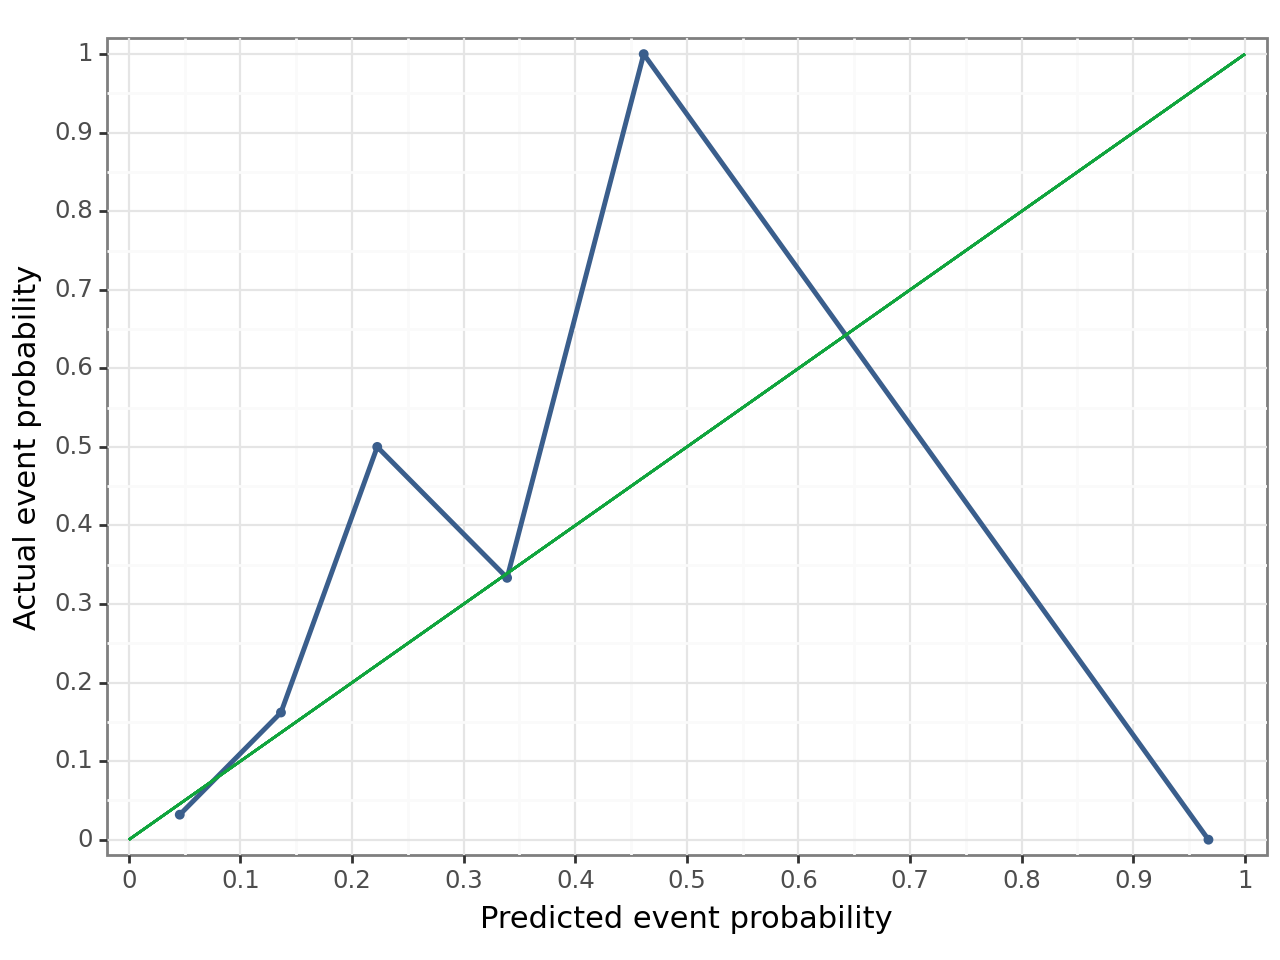

<Figure Size: (640 x 480)>

In [63]:
create_calibration_plot(
    holdout_df,
    'Test',
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

Now we plot the M2 model

In [64]:
best_model = logit_models["M2"]
model_equation = "default~" + "+".join(M2)
_, X_holdout = patsy.dmatrices(model_equation, holdout_df)
holdout_df["best_logit_pred_proba"] = best_model.predict_proba(X_holdout)[:, 1]

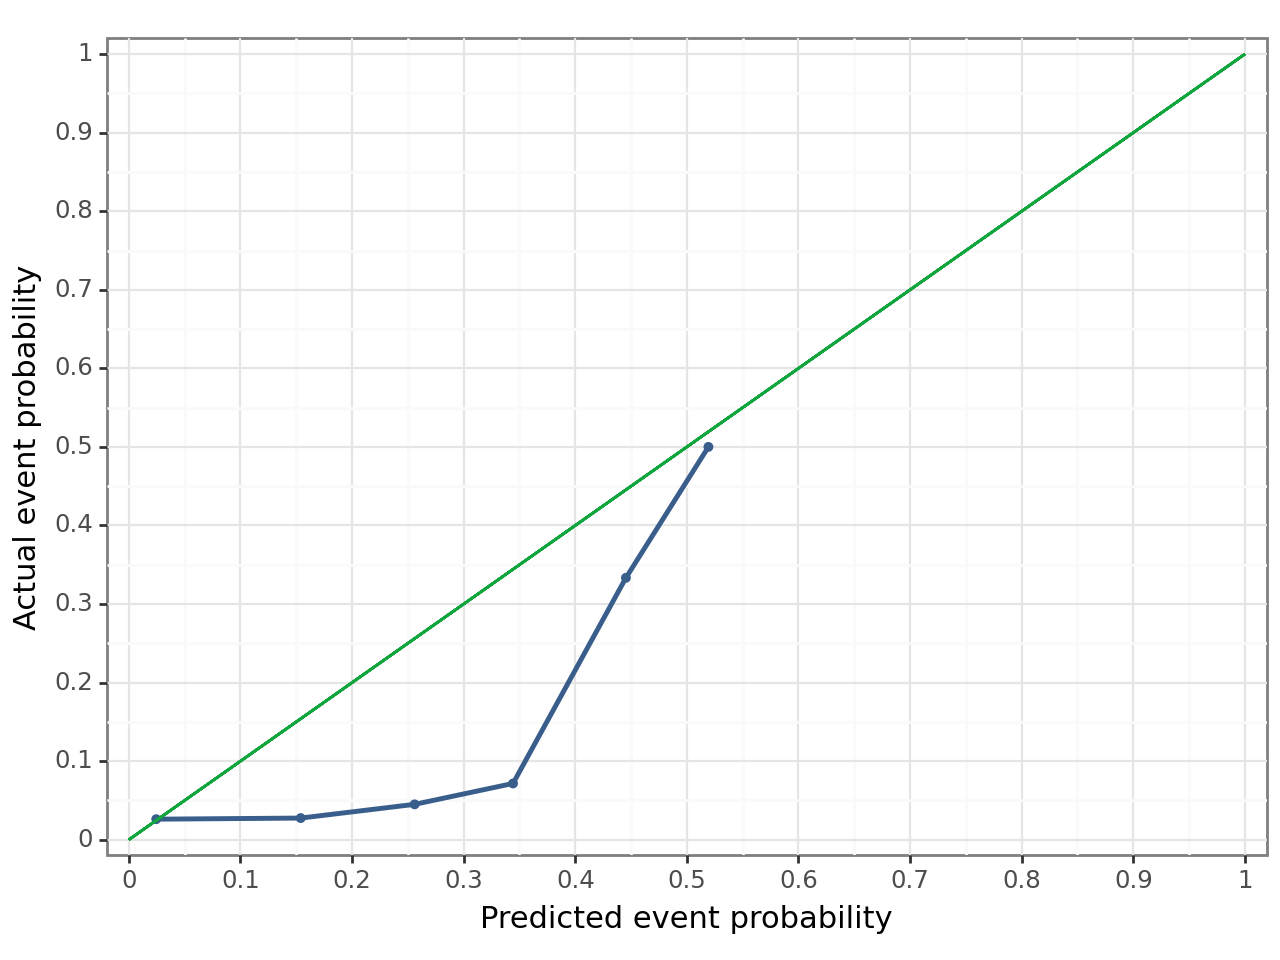

<Figure Size: (640 x 480)>

In [65]:
create_calibration_plot(
    holdout_df,
    'Test',
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

We set the expected loss formula with the following parameters: loss(FN) = 15, loss(FP) = 3 on the holdout set for calculated expected loss

In [66]:
FP = 3
FN = 15
cost = FN / FP
prevelance = y_train.sum() / len(y_train)

In [67]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), train_df)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = train_df["default"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [68]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [69]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.11251,0.13466,0.85303,0.90139
1,M2,0.41384,0.50484,0.88461,0.90294
2,LASSO,0.16532,0.12751,0.79544,0.83170


The table results above show the average expected loss calculated over the 5 folds using the training set. From the results we can see that the LASSO model has the lowest expected loss. This is unfortunately higher than we would prefer. Other models will be examined.
___
Below we plot the Loss Plot for the LASSO model showing the optimal threshold for limiting the number of False Negatives given our loss function.

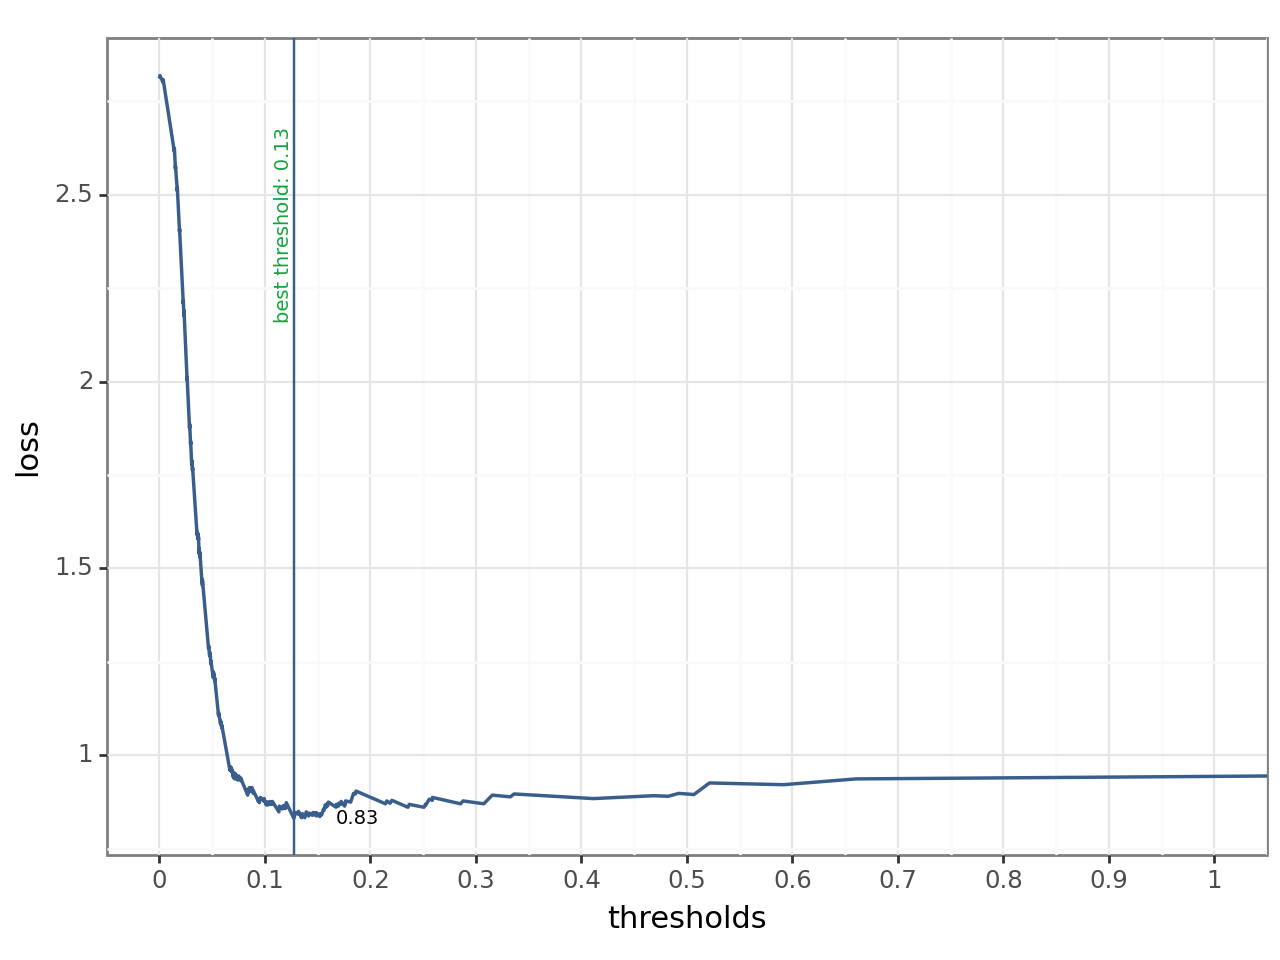

<Figure Size: (640 x 480)>

In [70]:
model_to_plot = "LASSO"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Below we show the ROC Curve for the LASSO model.

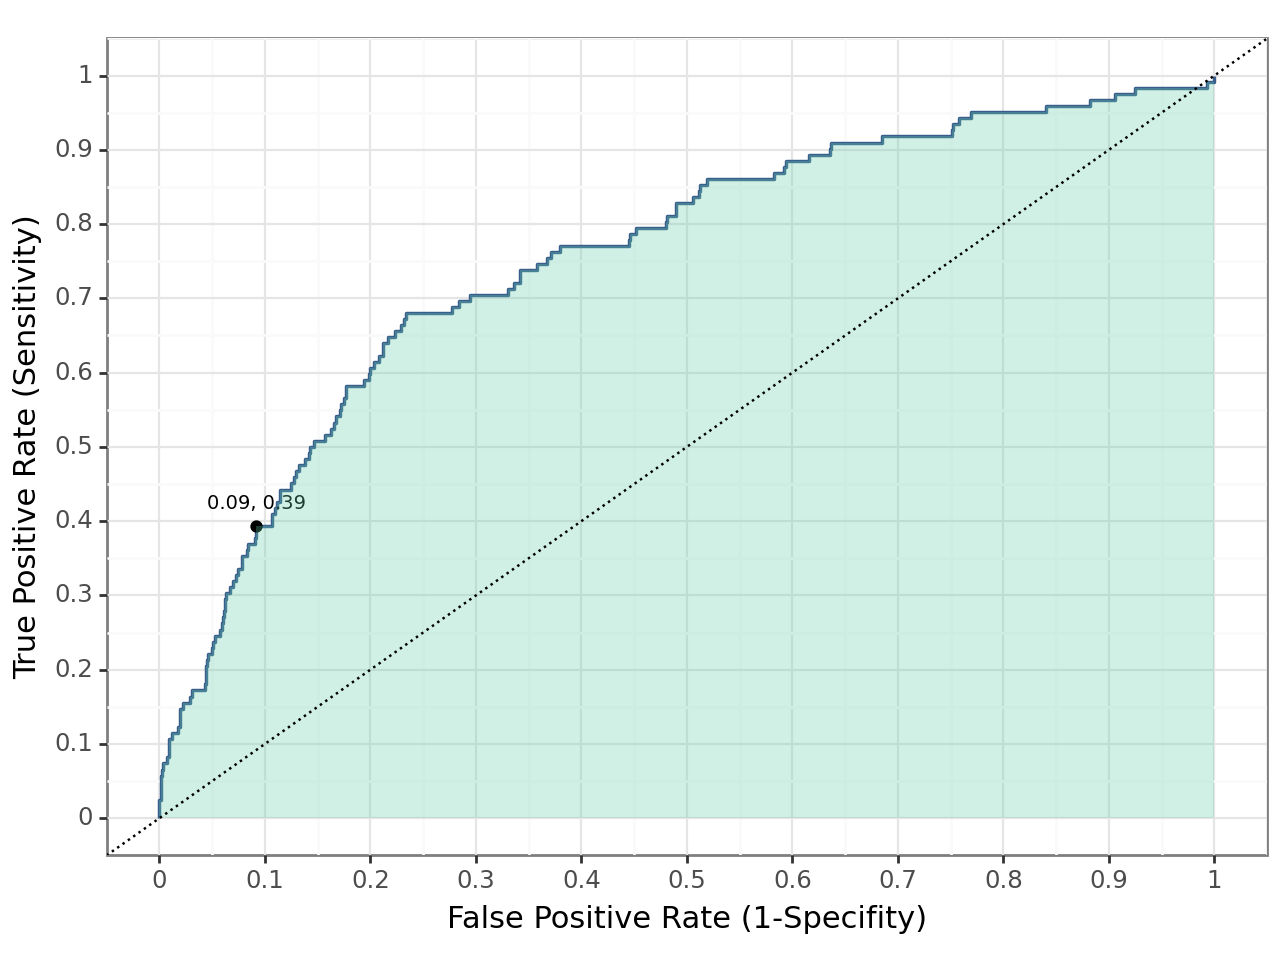

<Figure Size: (640 x 480)>

In [71]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

In [114]:
best_logit_optimal_treshold = best_thresholds_cv["LASSO"]

# Get expected loss on holdout
holdout_treshold = np.where(
    holdout_df["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    holdout_df["default"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(holdout_df["default"])
lasso_expected_loss = round(expected_loss_holdout, 3)
lasso_expected_loss

2.008

In [73]:
cm_object3 = confusion_matrix(holdout_df["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actul no defaul,327,654
Actual default,8,48


Here we can see that the LASSO model does a very poor job of predicting defaults. It greatly limits the amount of false negatives but at the massive cost of producing a ton of false positives. While false positives are penalized less by our loss function than false negatives, this is still not an acceptable tradeoff when running the Logit LASSO on the holdout set. This is why the expected loss value on the holdout set is 2.008

# Random Forest
We create a Random Forest model fitting for accuracy using the shortlisted variables from the LASSO model defined above. We do this in order to only use the terms that are deemed to be significant according to the LASSO in order to not get more noisy and/or biased results from the Random Forest algorithm.

In [117]:
k = KFold(n_splits=5, shuffle=True, random_state=20240229)

In [118]:
# Setting the training variables
X_train = train_df[shortlist_vars]
y_train = train_df['default']

max_features = [6, 7, 8]
min_samples = [7, 9, 11]
zero_len = len(max_features)*len(min_samples)


# Define parameter grid for GridSearchCV
grid = {'max_features': max_features,
        'criterion':['gini'],
        'min_samples_split': min_samples}

random_forest = RandomForestClassifier(random_state=20240229, n_estimators=500, oob_score=True)
    
# Create GridSearchCV
random_forest_grid = GridSearchCV(random_forest, grid, cv=k, refit='accuracy', scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [119]:
%%time

# Running the Random Forest Model
random_forest_fit = random_forest_grid.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 6min 20s


In [120]:
rf_accuracy = np.zeros([zero_len])
for i in range(5):
    rf_accuracy += random_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
rf_accuracy /= 5
rf_accuracy

array([0.93817741, 0.93807421, 0.93807426, 0.93828077, 0.93848711,
       0.93797101, 0.93776466, 0.93807426, 0.93817746])

In [121]:
rf_auc = np.zeros([zero_len])
for i in range(5):
    rf_auc += random_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
rf_auc /= 5
rf_auc

array([0.77595466, 0.77594344, 0.77698545, 0.77636241, 0.77680378,
       0.77695677, 0.77641224, 0.77814088, 0.77368113])

In [122]:
rf_rmse = np.zeros([zero_len])
for i in range(5):
    rf_rmse += np.sqrt(-1*(random_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
rf_rmse /= 5
rf_rmse

array([0.22980291, 0.22987989, 0.22981907, 0.23020946, 0.23009999,
       0.23012935, 0.23027289, 0.23006411, 0.2301001 ])

In [123]:
random_forest_cv_results = pd.DataFrame({
    'max_features': random_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': random_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': rf_accuracy,
    'cv_auc': rf_auc,
    'cv_rmse': rf_rmse
})
random_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,6,7,0.93818,0.77595,0.22980
1,6,9,0.93807,0.77594,0.22988
2,6,11,0.93807,0.77699,0.22982
3,7,7,0.93828,0.77636,0.23021
4,7,9,0.93849,0.77680,0.23010
5,7,11,0.93797,0.77696,0.23013
6,8,7,0.93776,0.77641,0.23027
7,8,9,0.93807,0.77814,0.23006
8,8,11,0.93818,0.77368,0.23010


In [124]:
best_mtry = random_forest_fit.best_params_["max_features"]
best_min_node_size = random_forest_fit.best_params_["min_samples_split"]
random_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 9}

In [125]:
prob_forest_best_results = random_forest_cv_results[
    (random_forest_cv_results.max_features == best_mtry)
    & (random_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

Displaying the best results for the RF model

In [126]:
prob_forest_best_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
4,7,9,0.93849,0.77680,0.23010


In [127]:
summary.loc["RF", "Number of Coefficients"] = len(shortlist_vars)
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,16.00000,0.23661,0.70373,0.11251,0.85303
M2,37.00000,0.34289,0.66335,0.41384,0.88461
LASSO,38.00000,0.23181,0.75826,0.16532,0.79544
RF,38.00000,0.23010,0.77680,0.21614,0.76045


From the results above we can see that the RF model has a better AUC score and RMSE than the other models using the shortlisted LASSO coefficients. From this we can gather that the algorithms from the RF are doing a better job of splitting the data than our theoretical OLS models do.

In [128]:
FP = 3
FN = 15
cost = FN / FP
prevelance = y_train.sum() / len(y_train)

In [129]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(X_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = train_df["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = train_df["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=20240229,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [130]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [131]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.23000,0.77700,0.21600,0.29500,0.76000,0.77300


Above we have the average expected loss, average optimal threshold, and the same respective values for the 5th fold for the RF model based on the training set. We can see that the model outperforms the LASSO model in every respect.
___
Below we create a Loss Plot of the RF showing the optimal threshold defined by our loss function.

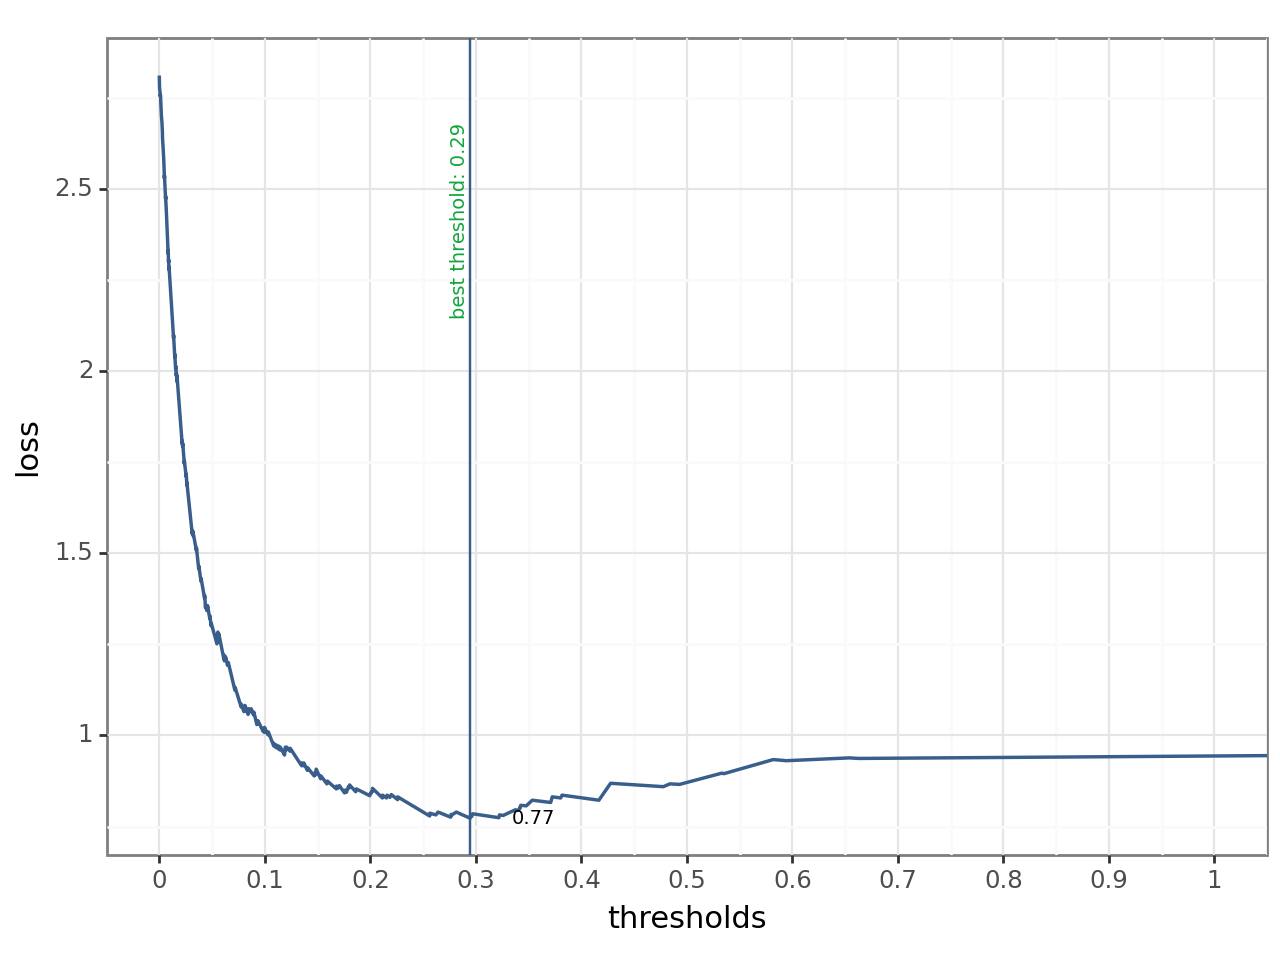

<Figure Size: (640 x 480)>

In [132]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

Below is the ROC Curve for the RF model.

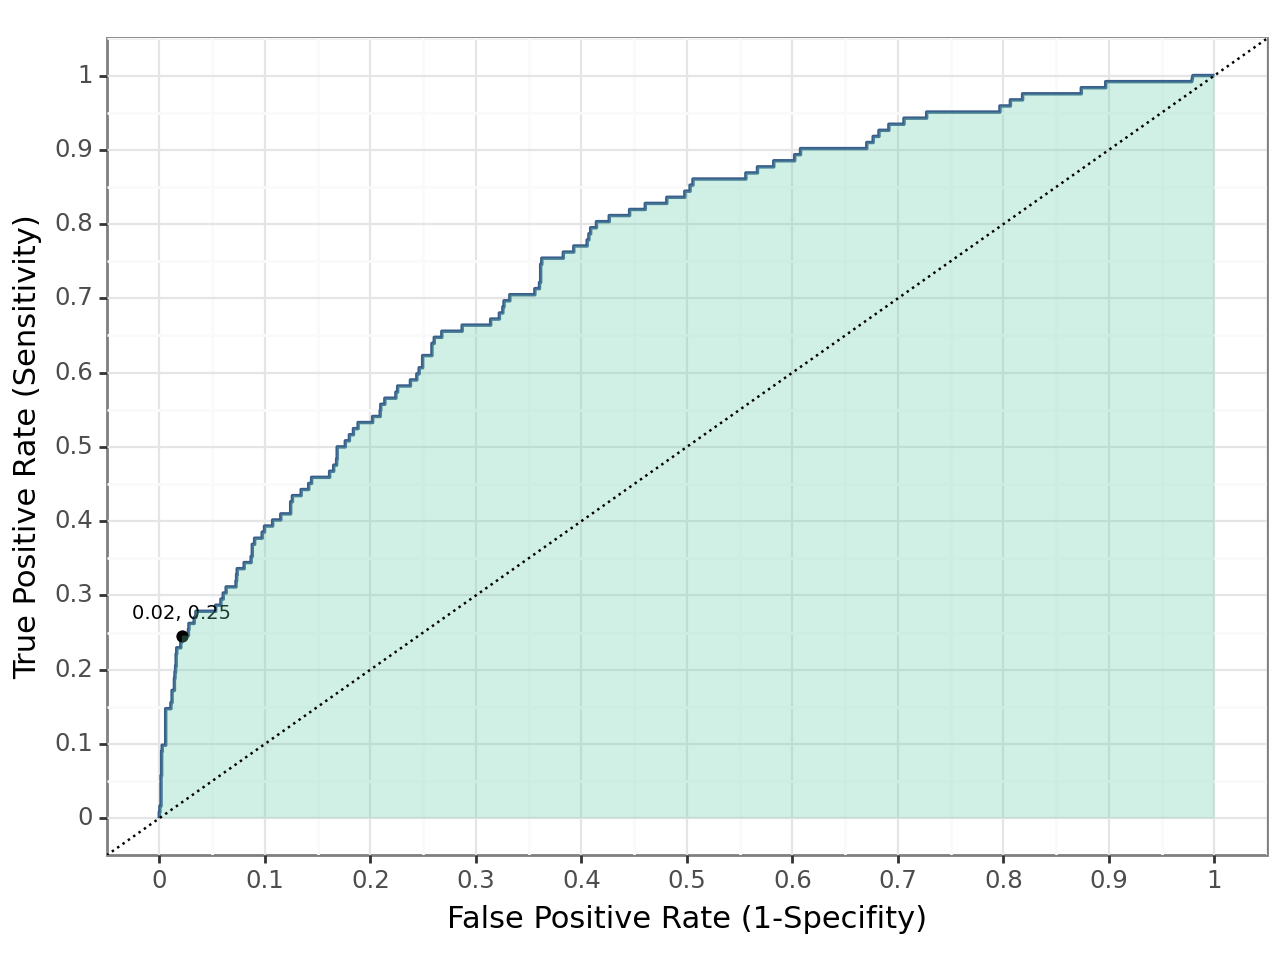

<Figure Size: (640 x 480)>

In [133]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

From the Loss Plot we can see that the optimal threshold is .29 and that the loss flattens out at around .6.

The ROC curve for the RF model shows that the model performs better than a baseline prediction with the best value being at the .02 FP and .25 TP rate. From this we can infer that the model does better at predicting firms defaulting at the smaller size than the medium sizes.

In [134]:
# Setting the training variables
X_holdout = holdout_df[shortlist_vars]
y_holdout = holdout_df['default']

In [135]:
prob_forest_fit_best = random_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(X_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.21

In [137]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.823

In [138]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
rf_expected_loss = round(expected_loss_holdout, 4)
rf_expected_loss

0.5641

Above is the expected loss value of the RF model on the holdout set. We can see that it vastly outperforms the LASSO model.

In [95]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [96]:
summary.round(4)

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,16.00000,0.23660,0.70370,0.11250,0.85300
M2,37.00000,0.34290,0.66340,0.41380,0.88460
LASSO,38.00000,0.23180,0.75830,0.16530,0.79540
RF,38.00000,0.23010,0.77680,0.21610,0.76050


Above we can see a comparison of all the models created so far. The RF model has the best AUC score and the lowest excepted loss when used on the training set.

In [97]:
cm_object3 = confusion_matrix(holdout_df["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actual no default,946,35
Actual default,32,24


Here we can see the performance of the RF model on the holdout set. We see that it does a better job of correctly predicting defaults while getting lower false negatives (no default predict on a firm that actually defaults) than the LASSO model by far.

# GBM

In [98]:
# Setting the training variables
X_train = train_df[shortlist_vars]
y_train = train_df['default']

In [99]:
# Setting best model to a variable
rf_best = random_forest_fit.best_estimator_

# Creating a GBM Classifier object
gbm = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10, max_features=40)

# Setting tuning parameters
n_est = [200, 300]
max_dep = [6, 8]
gbm_zero_len = len(n_est) * len(max_dep)

# Assigning grid values
tune_grid = {'n_estimators': n_est, 'max_depth': max_dep}

# Setting model covariates via GridSearch
gbm_model_cv = GridSearchCV(gbm, tune_grid, cv=k, refit='accuracy', scoring=['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [100]:
%%time

# Running GBM
gbm_fit = gbm_model_cv.fit(X_train, y_train)

CPU times: total: 1min 44s
Wall time: 6min 7s


In [101]:
# Grabbing scores from GBM
gbm_accuracy = np.zeros(gbm_zero_len)
gbm_auc = np.zeros(gbm_zero_len)
gbm_rmse = np.zeros(gbm_zero_len)

# Extracting scores from cross-validation results
for i in range(5):
    gbm_accuracy += gbm_fit.cv_results_['split' + str(i) + '_test_accuracy']
    gbm_auc += gbm_fit.cv_results_['split' + str(i) + '_test_roc_auc']
    gbm_rmse += np.sqrt(-1 * gbm_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])

# Computing mean scores
gbm_accuracy /= 5
gbm_auc /= 5
gbm_rmse /= 5

In [102]:
# Displaying GBM results in a df
gbm_cv_results = pd.DataFrame({
    'max_depth': gbm_fit.cv_results_['param_max_depth'],
    'n_estimators': gbm_fit.cv_results_['param_n_estimators'],
    'cv_accuracy': gbm_accuracy,
    'cv_auc': gbm_auc,
    'cv_rmse': gbm_rmse
})
gbm_cv_results

,max_depth,n_estimators,cv_accuracy,cv_auc,cv_rmse
0,6,200,0.93642,0.75133,0.23703
1,6,300,0.93684,0.74423,0.23863
2,8,200,0.93498,0.74730,0.24011
3,8,300,0.93539,0.74621,0.24364


In [103]:
# Setting GBM best estimator to a variable
gbm_best = gbm_fit.best_estimator_
gbm_best 

GradientBoostingClassifier(max_depth=6, max_features=40, min_samples_split=10,
                           n_estimators=300)

In [104]:
# Getting the best values to create a dataframe

# Random Forest
rf_best_max_features = random_forest_fit.best_params_['max_features']
rf_best_min_sample_split = random_forest_fit.best_params_['min_samples_split']

rf_best_results = random_forest_cv_results[
    (random_forest_cv_results.max_features == rf_best_max_features) & 
    (random_forest_cv_results.min_samples_split == rf_best_min_sample_split)]
rf_best_results_index = rf_best_results.index.values[0]

# GBM
gbm_best_max_depth = gbm_fit.best_params_['max_depth']
gbm_best_n_estimators = gbm_fit.best_params_['n_estimators']

gbm_best_results = gbm_cv_results[
    (gbm_cv_results.max_depth == gbm_best_max_depth) &
    (gbm_cv_results.n_estimators == gbm_best_n_estimators)]
gbm_best_results_index = gbm_best_results.index.values[0]

In [105]:
best_thresholds = list()
expected_loss = list()
gbm_train = pd.DataFrame(X_train)

fold = 0
for train_index, test_index in k.split(gbm_train):
    X_fold = gbm_train.iloc[test_index, :]
    y_fold = train_df["default"].iloc[test_index]

    X_fold_train = gbm_train.iloc[train_index, :]
    y_fold_train = train_df["default"].iloc[train_index]

    gbm_best_classifier = GradientBoostingClassifier(
        random_state=20240229,
        n_estimators=gbm_best_n_estimators,
        max_depth = gbm_best_max_depth,
        min_samples_split = 10,
    )
    
    gbm_best_fold = gbm_best.fit(X_fold_train, y_fold_train)
    gbm_pred_fold = gbm_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, gbm_pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(gbm_pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [106]:
expected_loss_cv["GBM"] = np.mean(expected_loss)
best_thresholds_cv["GBM"] = np.mean(best_thresholds)

In [107]:
gbm_summary = pd.DataFrame(
    {
        "CV RMSE": [round(gbm_best_results["cv_rmse"].values[0], 5)],
        "CV AUC": [round(gbm_best_results["cv_auc"].values[0], 5)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["GBM"], 5)],
        "Threshold for Fold5": [round(best_threshold, 5)],
        "Avg expected loss": [round(expected_loss_cv["GBM"], 5)],
        "Expected loss for Fold5": [round(curr_exp_loss, 5)],
    }
)

gbm_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.23863,0.74423,0.15789,0.44301,0.79606,0.84409


In [108]:
# Setting the training variables
X_holdout = holdout_df[shortlist_vars]
y_holdout = holdout_df['default']

In [109]:
prob_forest_fit_best = gbm_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(X_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.219

In [110]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.797

In [116]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
gbm_expected_loss = round(expected_loss_holdout, 3)
gbm_expected_loss

0.677

In [112]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [113]:
cm_object3 = confusion_matrix(holdout_df["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actul no defaul,962,19
Actual default,43,13


# Model Comparisons Based on Expected Loss on Holdout

In [139]:
# Creating dataframe to display results neatly
pd.DataFrame({'Model':['LASSO','RF','GBM'], 'Expected Loss on Holdout': [lasso_expected_loss, rf_expected_loss, gbm_expected_loss]})

,Model,Expected Loss on Holdout
0,LASSO,2.00800
1,RF,0.56410
2,GBM,0.67700


From this we can see that the Random Forest model is our best predictive model for predicting defaults in EU firms given our loss function definition.

Below will be values and plots that are generated from the holdout set using the RF model's best estimator.

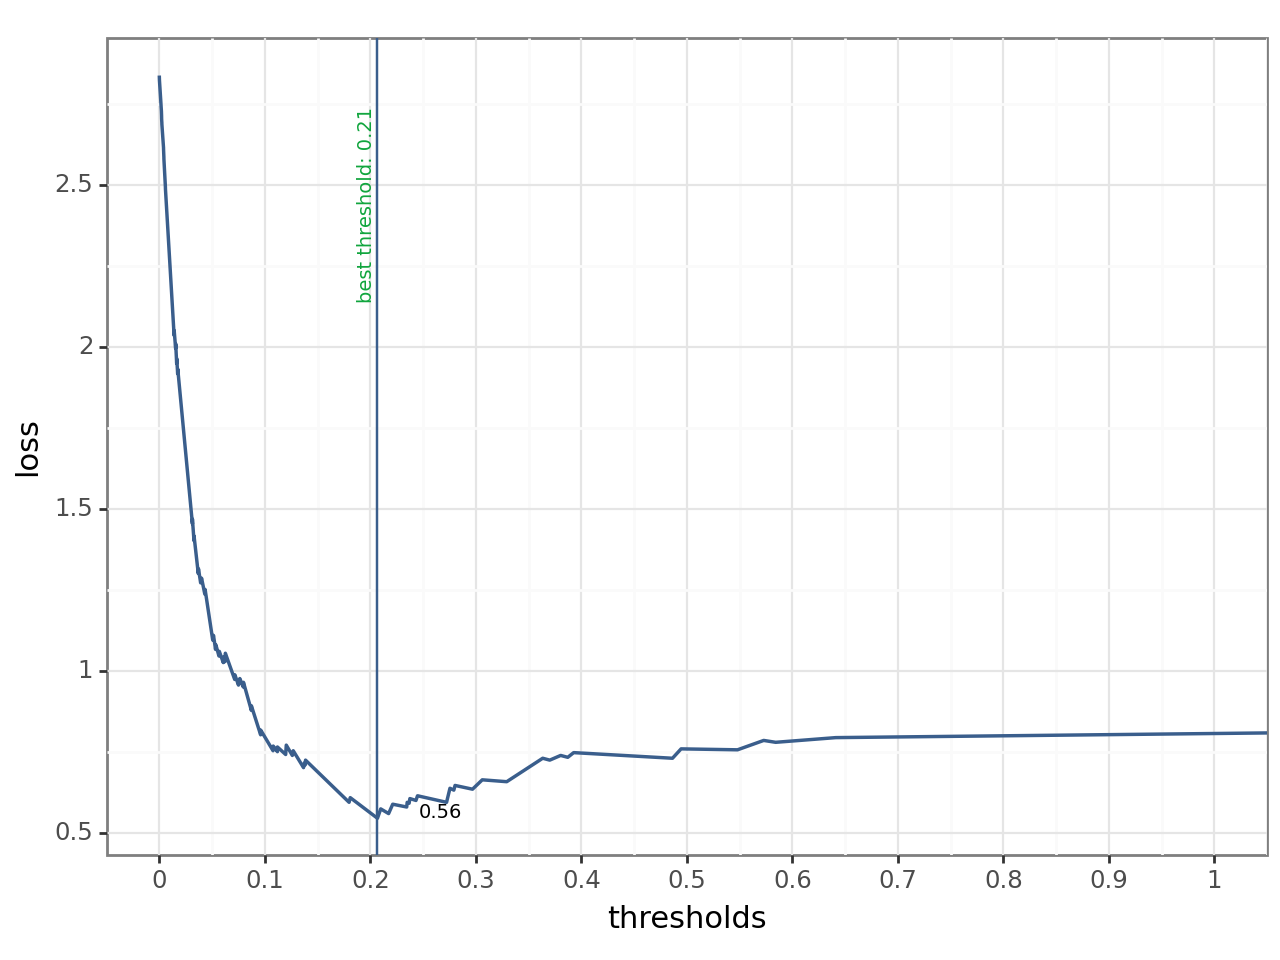

<Figure Size: (640 x 480)>

In [154]:
false_pos_holdout, true_pos_holdout, threshold_holdout = roc_curve(y_holdout, rf_predicted_probabilities_holdout)

holdout_best_threshold = sorted(list(zip(np.abs(true_pos_holdout + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_holdout)), threshold_holdout,)), key=lambda x: x[0], reverse=True,)[0][1]

holdout_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_holdout * sum(y_holdout == 0),
        "true_pos": true_pos_holdout * sum(y_holdout == 1),
        "false_neg": sum(y_holdout == 1) - true_pos_holdout * sum(y_holdout == 1),
        "true_neg": sum(y_holdout == 0) - false_pos_holdout * sum(y_holdout == 0),
        "pos": sum(y_holdout == 1),
        "neg": sum(y_holdout == 0),
        "n": len(y_holdout),
        "thresholds": threshold_holdout
    }
)

create_loss_plot(holdout_coords_rf, holdout_best_threshold, rf_expected_loss)

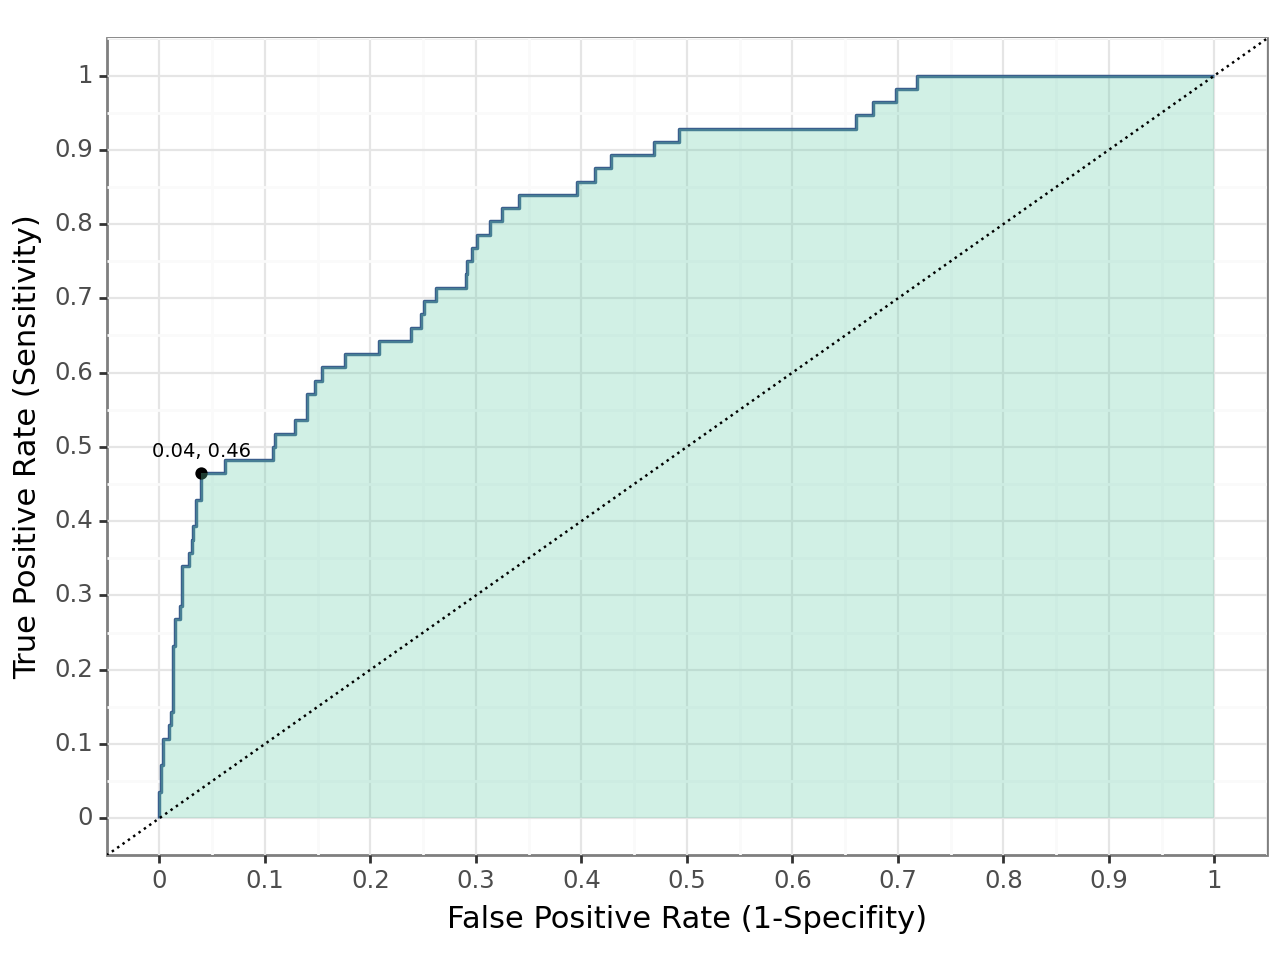

<Figure Size: (640 x 480)>

In [152]:
create_roc_plot_with_optimal(holdout_coords_rf, holdout_best_threshold)

In [170]:
tnh, fph, fnh, tph = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()

pd.DataFrame({'Model':'RF',
              'Holdout Brier': round(brier_score_loss(y_holdout, rf_predicted_probabilities_holdout), 4),
              'Holdout AUC': round(auc_rf, 4),
              'Holdout Accuracy': round(accuracy_score(y_holdout, prob_forest_fit_best.predict(X_holdout)), 4),
              'Optimal Threshold Sensitivity': round(tph / (tph + fnh), 4),
              'Optimal Threshold Specificity': round(tnh / (tnh + fph), 4)
             },
             index=[0])

,Model,Holdout Brier,Holdout AUC,Holdout Accuracy,Optimal Threshold Sensitivity,Optimal Threshold Specificity
0,RF,0.04400,0.82260,0.94790,0.42860,0.96430


In [173]:
holdout_df['default'].describe()

count   1037.00000
mean       0.05400
std        0.22613
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max        1.00000
Name: default, dtype: float64